In [1]:
import copy
import errno
import numpy as np
import pandas as pd
import os
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.interpolate as spi
import scipy.stats as sps

Jobs to do: 

Must do:
- Read through each of these functions to try to understand how they work. You might need to look at the data files for the data loading functions to make sense. Make notes of any lines of code, or any of the logic that either don't make sense, or you think might be wrong. There is a fair chance I have made a mistake or two. 

- Check, and if necessary, update the list of solar cycle start, maximum and end times in the function add_solar_cycle_phase_to_dataframe(). I took these from wikipedia, and although they are unlikely to be terribly wrong, it would be good to check that these haven't changed, and even better still if they could be replaced from times provided by an academic reference.

Good to do:

- Add a legend to the time series plot and superposed epoch plot, so that readers know what each line represents. Good resources to work out how to do this are google, stack overflow, and the matplotlib API reference guide.

Challenge:

- Add in another panel to the superposed epoch plot to include the superposed epoch of the CME count. This might look a bit "ratty", as there is much less CME count data. But it would be good to see how it looks. There are examples of all the code you need to do this below, but you will need to identify which bits and how to modify them to make it work.  

In [2]:
def project_info():
    """
    A function to create a dictionary of project directories, pointing to the different data files and folders, stored
    in config.txt
    :return dirs: Dictionary of project directories.
    """  
    # Get root directory of the project
    root = "C:/Users/yq904481/research/repos/SolarCycle25" # Danny, you'll need to change this line to make it work on your computer
    
    # The config file must be stored in the same directory as the workbook
    config_file = 'config.dat'
    if os.path.isfile(config_file):
        
        with open(config_file, 'r') as file:
            lines = file.read().splitlines()
            dirs = {line.split(',')[0]: os.path.join(root, line.split(',')[1]) for line in lines}
            
        dirs['root'] = root

        # Just check the directories exist.
        for key, val in dirs.items():
            if key in ['sunspot_data', 'dst_data', 'tsi_data', 'f10p7_data', 'cme_data']:
                if not os.path.isfile(val):
                    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), val)
            else:
                if not os.path.isdir(val):
                    raise NotADirectoryError(errno.ENOENT, os.strerror(errno.ENOENT), val)
    else:
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), config_file)
                
    return dirs


def load_ssn_data():
    """
    Function to load in the daily sunspot data from SILSO (version 2.0). Data taken directly from SILSO
    http://www.sidc.be/silso/datafiles
    :return: DF - Dataframe containing the daily sunspot count, including fields:
       time     : Datetime index of observation
       ssn      : Daily sunspot number
    """
    # Load the data into pandas, use some converters to get the dtypes correct.
    proj_dirs = project_info()
    file_path = proj_dirs['sunspot_data']
    colnam = ['year', 'month', 'day', 'deciyear', 'ssn', 'sigma', 'N', 'Q']
    dtype = {'year': 'str', 'month': 'str', 'day': 'str', 'hour': 'str'}
    df = pd.read_csv(file_path, names=colnam, na_values="  -1", dtype=dtype, sep=';')
    # Times are a mess, calculate datetime for each index and tidy up arrays
    df['time'] = pd.to_datetime(df.year + df.month + df.day, format="%Y%m%d")
    df.drop(['year', 'month', 'day', 'sigma', 'N', 'Q', 'deciyear'], axis=1, inplace=True)
    df.set_index('time', inplace=True, drop=True)
    return df


def load_dst_data():
    """
    Function to load in the hourly Dst index data, compute daily mean, and return this in a dataframe.
    :return: DF - Dataframe containing the daily mean Dst index, including fields:
       time     : Datetime index of observation
       dst      : Daily mean Dst index
    """
    
    proj_dirs = project_info()
    file_path = proj_dirs['dst_data']
    colnam = ['date', 'time', 'doy', 'dst']
    dtype = {'date': 'str', 'time': 'str', 'doy': 'int', 'val': 'float'}
    df = pd.read_csv(file_path, delim_whitespace=True, names=colnam, skiprows=25,
                     na_values='9999', dtype=dtype)
    
    # Times are a mess, calculate datetime for each index and tidy up arrays
    df['time'] = pd.to_datetime(df.date + 'T' + df.time, format="%Y-%m-%dT%H:%M:%S")
    df.set_index('time', inplace=True, drop=True)
    df.drop(['date', 'doy'], axis=1, inplace=True)
    # Compute daily mean
    df = df.resample('D').mean()
    return df


def load_f10p7_data():
    """
    Function to load in the f10.7 index data, compute daily mean, and return this in a dataframe.
    :return: DF - Dataframe containing the daily mean Dst index, including fields:
       time     : Datetime index of observation
       f107     : Daily mean f10.7 index
    """
    
    proj_dirs = project_info()
    file_path = proj_dirs['f10p7_data']
    
    # Third column is the adjusted flux, which should be used for solar studies. obs_flux is affected by earth-sun sep.
    colnam = ['jd', 'obs_flux', 'f107']
    dtype = {'jd': 'float', 'obs_flux': 'float', 'f107': 'float'}
    df = pd.read_csv(file_path, sep=',', names=colnam, skiprows=1, na_values='0.0', dtype=dtype)
    df['time'] = pd.to_datetime(df['jd'], unit='D', origin='julian')
    df.set_index('time', inplace=True, drop=True)
    df.drop(['jd', 'obs_flux'], axis=1, inplace=True)
    # Resample to daily mean
    df = df.resample('D').mean()
    return df


def load_tsi_data():
    """
    Function to load in the total solar irradiance (tsi) data, compute the daily mean value, and return this in a dataframe.
    :return: DF - Dataframe containing the daily mean Dst index, including fields:
       time     : Datetime index of observation
       tsi      : Daily mean tsi data
    """

    proj_dirs = project_info()
    file_path = proj_dirs['tsi_data']

    jd_ref = 2309100.5 #JD of 1610-01-01, which is the reference date used in the TSI data.
    colnam = ['mjd', 'tsi', 'tsi_unc']
    dtype = {'mjd': 'float', 'tsi': 'float', 'tsi_unc': 'float'}
    df = pd.read_csv(file_path, sep=',', names=colnam, skiprows=1, na_values='0.0', dtype=dtype)
    df['jd'] = df['mjd'] + jd_ref
    df['time'] = pd.to_datetime(df['jd'], unit='D', origin='julian')
    df.set_index('time', inplace=True, drop=True)
    df.drop(['jd', 'mjd', 'tsi_unc'], axis=1, inplace=True)
    # Resample to daily mean
    df = df.resample('D').mean()
    return df


def load_cme_data():
    """
    Function to load in LASCO CDAW CME Catalogue, and compute the daily CME count and return this in a dataframe.
    :return: DF - Dataframe containing the daily mean Dst index, including fields:
       time     : Datetime index of observation
       cmes     : Daily CME count
    """

    proj_dirs = project_info()
    file_path = proj_dirs['cme_data']

    # Load in the raw data, and remove all columns past speed. This is necessary, as CDAW have been fuckwits with their separators.
    with open(file_path, 'r') as f:
        lines = f.readlines()
        lines_sub = []
        for i, line in enumerate(lines):
            if i < 4:
                lines_sub.append(line)
            else:
                lines_sub.append(line[0:42]+"\n")

    # Save the reduced dataset to a new file
    new_file_path = os.path.join(proj_dirs['data'], 'cdaw_lasco_cme_subset.dat')            
    with open(new_file_path, 'w') as f:
        f.writelines(lines_sub)

    # Load reduced dataset into a padndas dataframe
    colnam = ['date', 'time', 'PA', 'width', 'speed']
    dtype = {'date': 'str', 'time': 'str', 'PA': 'float', 'width': 'float', 'speed': 'float'}
    df = pd.read_csv(new_file_path, skiprows=5, names=colnam, delim_whitespace=True, na_values='Halo')
    # Times are a mess, calculate datetime for each index and tidy up arrays
    df['time'] = pd.to_datetime(df['date'] +'T'+ df['time'], format="%Y/%m/%dT%H:%M:%S")
    df.drop(['date'], axis=1, inplace=True)
    df.set_index('time', inplace=True, drop=True)

    # Take a count of the CMEs on each day in the data set
    df_agg = df.groupby(df.index.date).count()
    df_agg['cmes'] = df_agg['width']
    df_agg.drop(['PA', 'width', 'speed'], axis=1, inplace=True)

    # Make a dataframe of CME count that is padded for every day between
    # start and end of CDAW list
    days = pd.date_range('1996-01-01', '2022-06-30')
    cmes = pd.DataFrame(index=days)
    # Join this with the daily aggreated CDAW list to get daily CME rate. 
    cmes = cmes.join(df_agg)
    # Replace invalids (where CME days were missing) with 0
    cmes.loc[cmes['cmes'].isna(), 'cmes'] = 0
    return cmes


def add_solar_cycle_phase_to_dataframe(df):
    """
    Function to calculate the solar cycle number, solar cycle phase (between 0-2pi), epoch time (days through cycle) and solar cycle
    state (rising=+1, falling=-1) for an array of times in a dataframe. Dates taken from Wikipedia, could be improved.
    :param df: A dataframe with column "time", which is datetime. 
    :return: Adds columns to df for solar cycle number, solar cycle phase, and solar cycle state
    """
    
    df['phase'] = np.NaN
    df['sc_num'] = np.NaN
    df['sc_state'] = 0

    start_times_list = ['1744-01-01', '1755-08-01', '1766-03-01', '1775-08-01', '1784-06-01', '1798-06-01',
                        '1810-06-01', '1823-12-01', '1833-10-01', '1843-09-01', '1855-03-01',
                        '1867-02-01', '1878-09-01', '1890-06-01', '1902-09-01', '1913-12-01',
                        '1923-05-01', '1933-09-01', '1944-01-01', '1954-02-01', '1964-10-01',
                        '1976-05-01', '1986-03-01', '1996-06-01', '2008-12-01', '2019-12-01']

    max_times_list = ['1748-01-01', '1761-06-01', '1769-09-01', '1778-05-01', '1788-02-01', '1805-02-01',
                      '1816-05-01', '1829-11-01', '1837-03-01', '1848-02-01', '1860-02-01',
                      '1870-08-01', '1883-12-01', '1894-01-01', '1906-02-01', '1917-08-01',
                      '1928-04-01', '1937-04-01', '1947-05-01', '1958-03-01', '1968-11-01',
                      '1979-12-01', '1989-07-01', '2000-03-01', '2014-04-01', '2024-01-01']

    end_times_list = ['1755-08-01', '1766-03-01', '1775-08-01', '1784-06-01', '1798-06-01',
                        '1810-06-01', '1823-12-01', '1833-10-01', '1843-09-01', '1855-03-01',
                        '1867-02-01', '1878-09-01', '1890-06-01', '1902-09-01', '1913-12-01',
                        '1923-05-01', '1933-09-01', '1944-01-01', '1954-02-01', '1964-10-01',
                        '1976-05-01', '1986-03-01', '1996-06-01', '2008-12-01', '2019-12-01', '2030-01-01']


    start_times = pd.to_datetime(start_times_list)
    max_times = pd.to_datetime(max_times_list)
    end_times = pd.to_datetime(end_times_list)

    # Calculate cycle lengths
    cycle_lengths = end_times.to_julian_date() - start_times.to_julian_date()
    
    # Calculate corresponding solar cycle numbers.
    sc_num = np.arange(0, len(start_times), dtype='int')

    solar_cycles = {i:{'start_time': start_times[i],
                       'max_time':max_times[i],
                       'end_time':end_times[i],
                       'length':cycle_lengths[i]} for i in sc_num}
    
    for sc_num, sc_times in solar_cycles.items():

        # Label solar cycle numbers
        id_sc = (df.index >= sc_times['start_time']) & (df.index < sc_times['end_time'])
        df.loc[id_sc, 'sc_num'] = sc_num
        df.loc[id_sc, 'epoch_time'] = df.loc[id_sc, 'jd'] - sc_times['start_time'].to_julian_date()
        df.loc[id_sc, 'phase'] = 2 * np.pi * df.loc[id_sc, 'epoch_time'] / sc_times['length']

        # Label ascending/descending phase
        id_sc = (df.index >= sc_times['start_time']) & (df.index < sc_times['max_time'])
        df.loc[id_sc, 'sc_state'] = 1
        
    return df


def load_data():
    """
    A function to load all of the individual data sets, including sunspot count, dst, f10.7, tsi, and cme rate,
    and import them all into one combined dataframe, to better enable the superposed epoch analysis
    """
    
    ssn = load_ssn_data()
    dst = load_dst_data()
    f107 = load_f10p7_data()
    tsi = load_tsi_data()
    cmes = load_cme_data()
    data = ssn.join([dst, f107, tsi, cmes])
    data['jd'] = pd.DatetimeIndex(data.index).to_julian_date()
    return data

data = load_data()

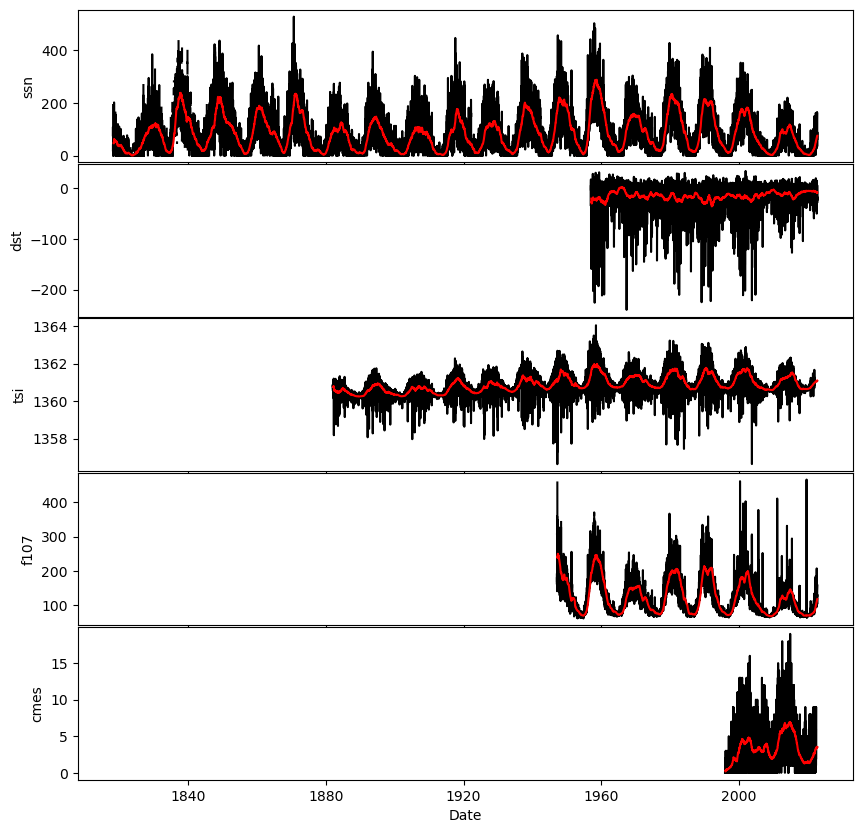

In [3]:
###############################################################
## MAKE A PLOT SHOWING THE TIME SERIES OF ALL THE PARAMETERS ##
###############################################################

# Load in the daily data of each parameter
data = load_data()

# Compute the 1 year rolling mean of these data, with minimum of 50 days of data in a "valid" average.
data_avg = data.rolling('365D', min_periods=50).mean()

# Create a 5 panel plot to plot these time series
fig, ax = plt.subplots(5, 1, figsize=(10,10))

# Loop through the keys of each parameter in the daily and yearly dataframes, and plot these data
for a, key in zip(ax, ['ssn', 'dst', 'tsi', 'f107', 'cmes']):
    
    # Plot the daily data, in black
    a.plot(data.index, data[key], 'k-')
    
    # Plot the 1 year rolling mean data, in red
    a.plot(data_avg.index, data_avg[key], 'r-')
    
    # Add the y axis label
    a.set_ylabel(key)

# Make sure all plots share common x axis limits (they should do already, but this just forces it)
xlims = ax[0].get_xlim()
for a in ax:
    a.set_xlim(xlims)
    
# Format the plot, remove intermediate x-axis labels, which are mostly clutter 
for a in ax[0:-1]:
    a.set_xticklabels([])
    
# Add x axis label    
ax[-1].set_xlabel('Date')

# Reduce dead space between plots
fig.subplots_adjust(hspace=0.01)

# Save the plot to file.
fig.savefig('sc25_time_series.png')

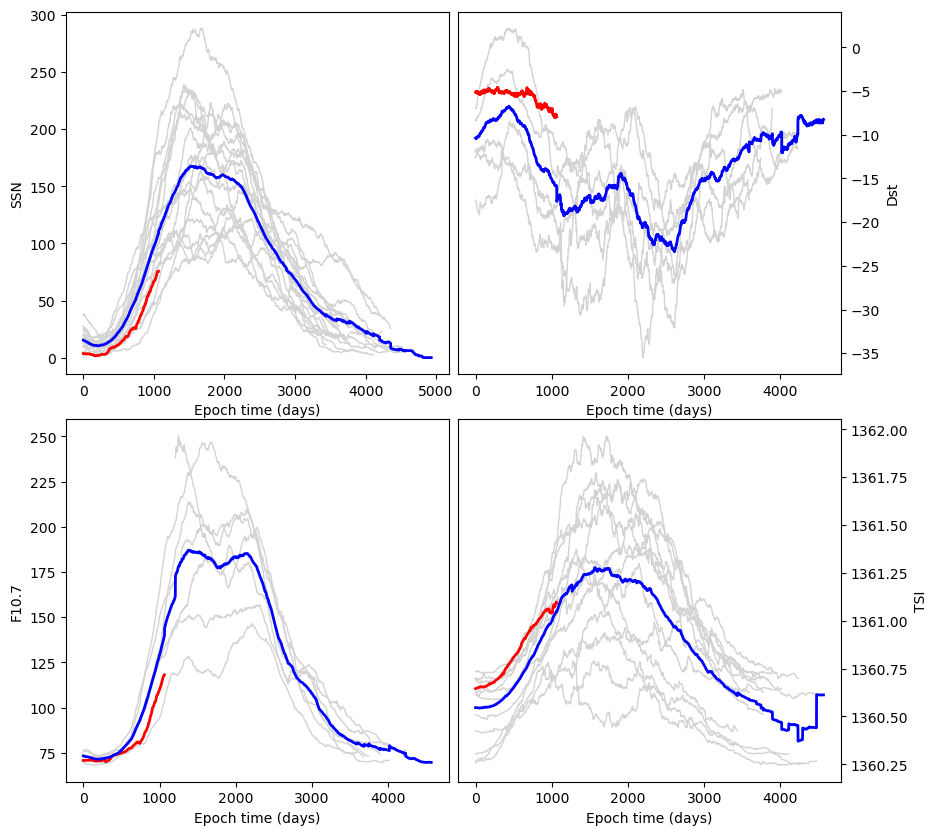

In [4]:
# Load in all of the data
data = load_data()

# Compute a 1 year rolling mean of the daily data
data_avg = data.rolling('365D', min_periods=50).mean()

# Update the julian day column, which is needed to compute the epoch times, and isn't handled correctly with the rolling mean.
data_avg['jd'] = pd.DatetimeIndex(data.index).to_julian_date()

# Add in the solar cycle phase and epoch time columns
data_avg = add_solar_cycle_phase_to_dataframe(data_avg)

# Now average the cycles together, to create the solar cycle superposed epoch analysis (sc_sea)
sc_sea = data_avg.groupby('epoch_time').mean()

# Create a figure to plot the superposed epoch analysis
fig, ax = plt.subplots(2, 2, figsize=(10,10))

# Loop through each solar cycle, plot the data for each cycle in gray, but color solar cycle 25 red.
for sc_num in data_avg['sc_num'].unique():
    
    # Find the dataframe indices corresponding to solar cycle sc_num
    id_sc = data_avg['sc_num'] == sc_num
    # Pull out the epoch time values for this solar cycle
    t = data_avg.loc[id_sc, 'epoch_time']
    
    # Now loop through the parameters to plot
    for a, key in zip(ax.ravel(), ['ssn', 'dst', 'f107', 'tsi']):
        
        # Pull out the paramter for this solar cycle
        val = data_avg.loc[id_sc, key]
        # Plot these values, grey for solar cycles before 25, red for 25.
        if sc_num < 25:
            a.plot(t, val, '-', color='lightgrey', linewidth=1)
        elif sc_num == 25:
            a.plot(t, val, '-', color='red', linewidth=2)
    
# Plot the superposed epoch analysis of each paramter
for a, key in zip(ax.ravel(), ['ssn', 'dst', 'f107', 'tsi']):
    a.plot(sc_sea.index, sc_sea[key], '-', color='blue', linewidth=2)

# Format the plot labels and spacings.
for a in ax[:,1]:
    a.yaxis.tick_right()
    a.yaxis.set_label_position("right")
    
for a in ax.ravel():
    a.set_xlabel('Epoch time (days)')
    
ax[0,0].set_ylabel('SSN')
ax[0,1].set_ylabel('Dst')    
ax[1,0].set_ylabel('F10.7')
ax[1,1].set_ylabel('TSI')
    
# Remove deadspace between panels
fig.subplots_adjust(wspace=0.025, hspace=0.125)

# Save to file
fig.savefig('sc25_superposed_epoch.png')